In [131]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [132]:
# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [133]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com


## Set number of clusters

In [134]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-2]



# clientIps = lines[-(nclusters):]
clientIps = lines[-2:]



2


In [135]:
clientIps, no_cluster_yet_nodes

(['127.0.0.1', '127.0.0.1'], ['127.0.0.1'])

## Functions

In [137]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S rm ../dump_files/nohup*.out; '
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S killall java;echo 1234 | sudo -S  killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S  killall java;echo 1234 | sudo -S  killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        

## Compile Job

## Setup Client and nodeIPS

In [139]:
len(lines)

11

In [138]:
len(nodeIps), len(clientIps)

(8, 2)

## RUN SERVERS

In [149]:
for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] pas

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 540ms
3 actionable tasks: 3 up-to-date


In [146]:
    
    
for i in range(len(lines)-3):
    run_server_node(i)
    

[sudo] password for tejas: 

Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/tejas/work/bftsmart_final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 6s
3 actionable tasks: 3 executed


[sudo] password for tejas: [sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such file or directory
[sudo] password for tejas: rm: cannot remove '../dump_files/nohup*.out': No such f

In [157]:
run_server_node(8)

In [155]:
run_server_node(0)

In [156]:
    
for i in range(1,len(lines)-3):
    run_server_node(i)

In [124]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- currentConsensusIdAsked activated
-- Received CID query from 1 with ID 4
-- Going to send back response to CID query with CID: -1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@12d4bf7e, remoteId: 1
-- Sent CID reply to replica 1 with ID 4
-- Tejas: Sending CID query with ID 4 to replicas [1, 2, 3]
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@7b227d8d, remoteId: 3
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@4c1d9d4b, remoteId: 2
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@12d4bf7e, remoteId: 1
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 3 with smsg.getCID() 5 (expecting queryID 5),  waitingCID -1, isInitializing true
-- smsg.getSender() 3, smsg.getState().getLastCID() -1
-- Received 1 replies for query ID 5
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSend

## Run basic client

In [158]:
for i in [8,9]:
    run_basic_client(i)

In [159]:
join_node1(8)

In [126]:
time.sleep(90)
for i in range(len(lines)):
    kill_java(i)
    


[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found


In [160]:
for i in range(len(lines)):
    kill_java(i)

[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found
[sudo] password for tejas: java: no process found
nohup: no process found


## Main Job

In [161]:
def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 


In [162]:
## Byzantine Remote View Change

In [163]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c8.out')

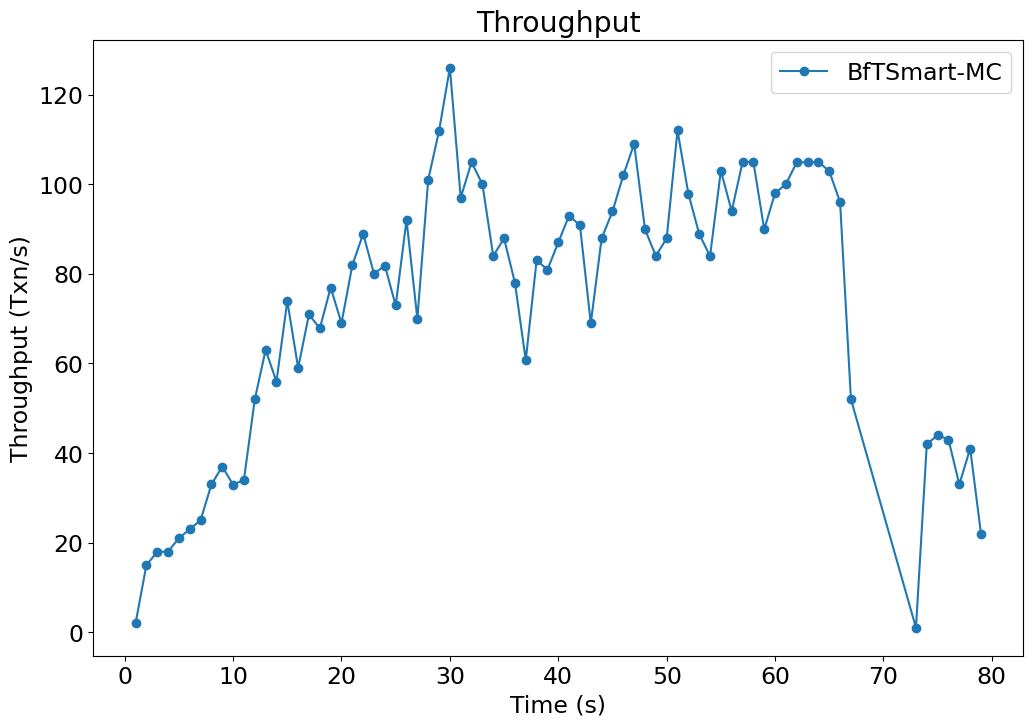

<Figure size 640x480 with 0 Axes>

In [164]:
import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()
